In [1]:
import numpy as np
import zarr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import pandas as pd
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.3.5


## Genetic differentiation and diversity within and between NZ and SA Mh
The purpose of this notebook is to calculate how differentiated the South American and New Zealand mh samples are. This is to work out how much divergence has taken place between them since Mh was reared and released into NZ, as well as to work out how diverse both population are.

Start by loading variants and metadata:

In [193]:
zarr_path = '/Users/dennistpw/Library/Mobile Documents/com~apple~CloudDocs/Projects/microctonus/microctonus_genom/snpdata/microctonus_fullcohort_filtered.zarr/'
callset = zarr.open_group(zarr_path, mode='r')
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['CHROM','POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'QUAL', 'MQRankSum', 'ReadPosRankSum', 'FS', 'SOR' ,'AF'])

df_samples = pd.read_csv('/Users/dennistpw/Library/Mobile Documents/com~apple~CloudDocs/Projects/microctonus/microctonus_genom/sampledata/myhponly_metadata.csv', index_col = 'order')

I'm sure there's a more elegant way of doing this but...make a dictionary of all the subpopulations we want to eventually analyse, and remove subpops with a small sample size (<10 usually)

In [128]:
subpops = {
    'all': list(range(len(df_samples))),
    'Ascasubi': df_samples[df_samples.Site == 'Ascasubi'].index.tolist(),
    'Bariloche': df_samples[df_samples.Site == 'Bariloche'].index.tolist(),
    'Featherston': df_samples[df_samples.Site == 'Featherston'].index.tolist(),
    'Fortrose': df_samples[df_samples.Site == 'Fortrose'].index.tolist(),
    'Hawkes_Bay': df_samples[df_samples.Site == 'Hawkes_Bay'].index.tolist(),
    'La_Serena': df_samples[df_samples.Site == 'La_Serena'].index.tolist(),
    'Lincoln': df_samples[df_samples.Site == 'Lincoln'].index.tolist(),
    'Mararoa': df_samples[df_samples.Site == 'Mararoa'].index.tolist(),
    'Mendoza': df_samples[df_samples.Site == 'Mendoza'].index.tolist(),
    'Mossburn': df_samples[df_samples.Site == 'Mossburn'].index.tolist(),
    'Porto_Alegre': df_samples[df_samples.Site == 'Porto_Alegre'].index.tolist(),
    'Rio_Negro': df_samples[df_samples.Site == 'Rio_Negro'].index.tolist(),
    'Ruakaka': df_samples[df_samples.Site == 'Ruakaka'].index.tolist(),
    'Ruakura': df_samples[df_samples.Site == 'Ruakura'].index.tolist(),
    'Concepcion': df_samples[df_samples.Site == 'Concepcion'].index.tolist(),
    'Colonia': df_samples[df_samples.Site == 'Colonia'].index.tolist(),
    'Greymouth': df_samples[df_samples.Site == 'Greymouth'].index.tolist(),
    'South_America': df_samples[df_samples.Region == 'South_America'].index.tolist(),
    'New_Zealand': df_samples[df_samples.Region == 'New_Zealand'].index.tolist(),
}

for key, value in subpops.items():
    #print value
    print(key, len(list(filter(bool, value))))
to_exclude = ['Ascasubi', 'Hawkes_Bay', 'La_Serena', 'Mararoa', 'Mendoza', 'Porto_Alegre', 'Rio_Negro', 'Ruakaka', 'Greymouth']


all 181
Ascasubi 2
Bariloche 11
Featherston 30
Fortrose 25
Hawkes_Bay 4
La_Serena 2
Lincoln 39
Mararoa 1
Mendoza 1
Mossburn 18
Porto_Alegre 3
Rio_Negro 4
Ruakaka 3
Ruakura 14
Concepcion 9
Colonia 11
Greymouth 4
South_America 43
New_Zealand 138


Remove pops < 9 inds (usually <10 but concepcion is marginal - we will keep and treat with caution)

In [129]:
for k in to_exclude:
    subpops.pop(k, None)

Define some functions that we'll use to iterate by chromosome and subpopulation. First, to make a manhattan line plot of fst over the chromosome (windows of 50 snps):

In [210]:
def plot_fst(ac1, ac2, pos, chrom, blen=50):
    
    fst, se, vb, _ = allel.blockwise_hudson_fst(ac1, ac2, blen=blen)
    
    # use the per-block average Fst as the Y coordinate
    y = vb
    
    # use the block centres as the X coordinate
    x = allel.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    # plot
    fig, ax = plt.subplots(figsize=(15, 4))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y, 'k-', lw=.5)
    ax.set_ylabel('$F_{ST}$')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.set_xlim(0, pos.max())
    plt.title(f"Fst (Hudson over {chrom}, av. {fst:.3}, +/- {se:.3}")

In [211]:
def do_fst_scafpop(pop1, pop2, chrom):
    #create boolean mask of vars by chrom
    mask = callset['variants/CHROM'][:]==chrom
    x = allel.GenotypeArray(callset['calldata/GT']) #extract gts
    scafgts = x.compress(mask, axis=0) #extract gts matching scaffold with mask
    acs = scafgts.count_alleles_subpops(subpops) #count alleles by subpop
    pos_all = allel.SortedIndex(variants.compress(mask)['POS']) #get pos corresponding to chr of interest
    acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:]) #get acs of subpops of interest
    flt = acu.is_segregating() & (acu.max_allele() == 1) #get alleles segregating our two subpops and remove multiallelics
    print('retaining', np.count_nonzero(flt), 'SNPs') #print how many we keep
    pos = pos_all.compress(flt) #filter
    ac1 = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2]) #ac of pop1
    ac2 = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2]) #ac of pop2
    plot_fst(ac1, ac2, pos, chrom) #call plotting function
    

Now, we'll iterate over the 12 main scaffolds and plot Hudson's fst between them. I chose Hudson's Fst (as opposed to Weir and Cockerham, for example), because it is more robust to differences in sample size (see Bhatia 2013).

retaining 175391 SNPs
retaining 148197 SNPs
retaining 134332 SNPs
retaining 106201 SNPs
retaining 113093 SNPs
retaining 98274 SNPs
retaining 89107 SNPs
retaining 77800 SNPs
retaining 72865 SNPs
retaining 54846 SNPs
retaining 56870 SNPs
retaining 27458 SNPs


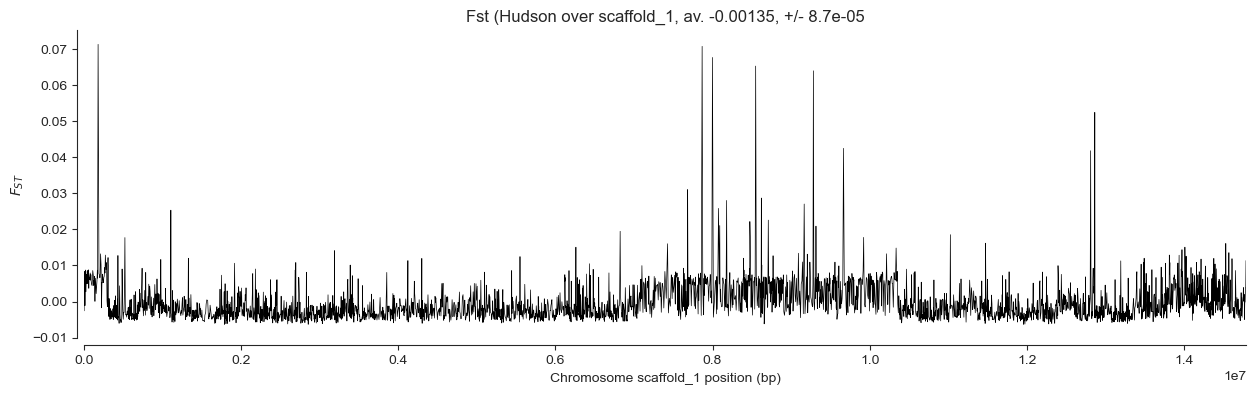

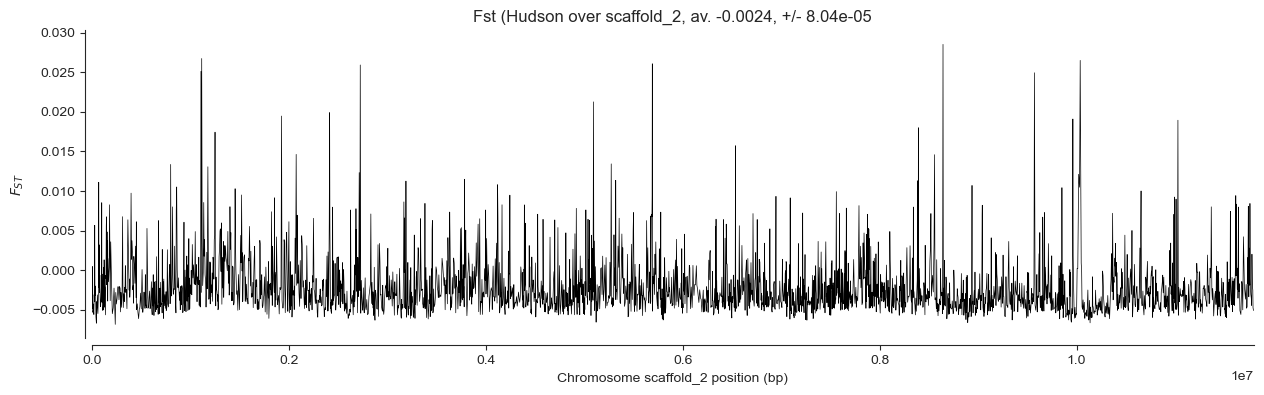

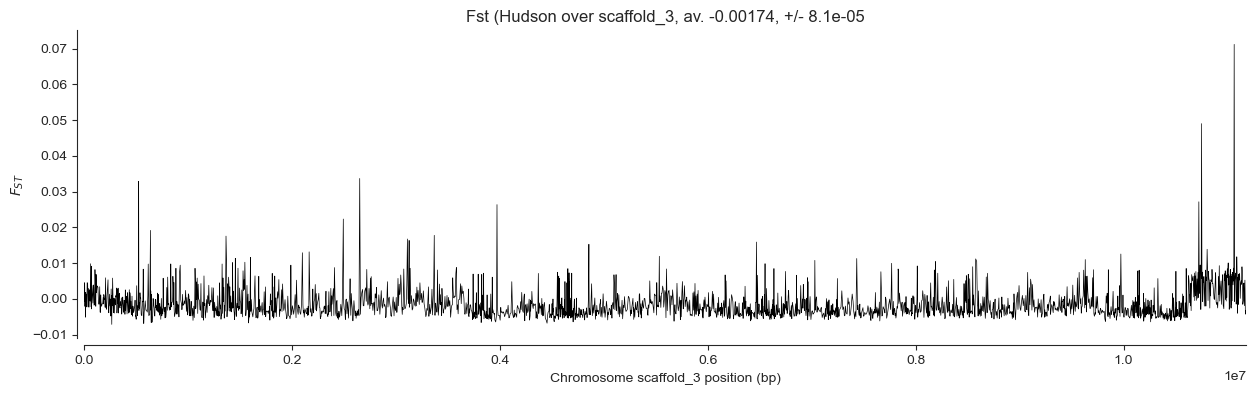

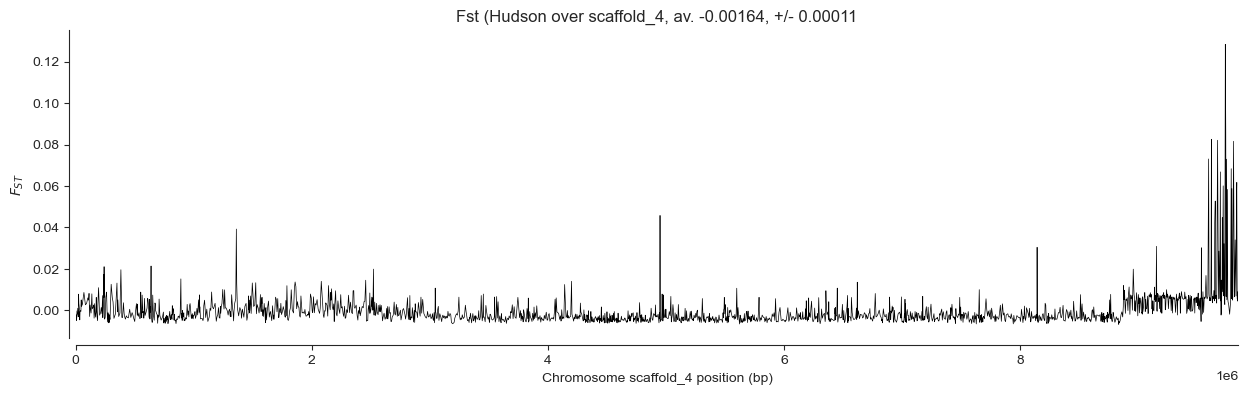

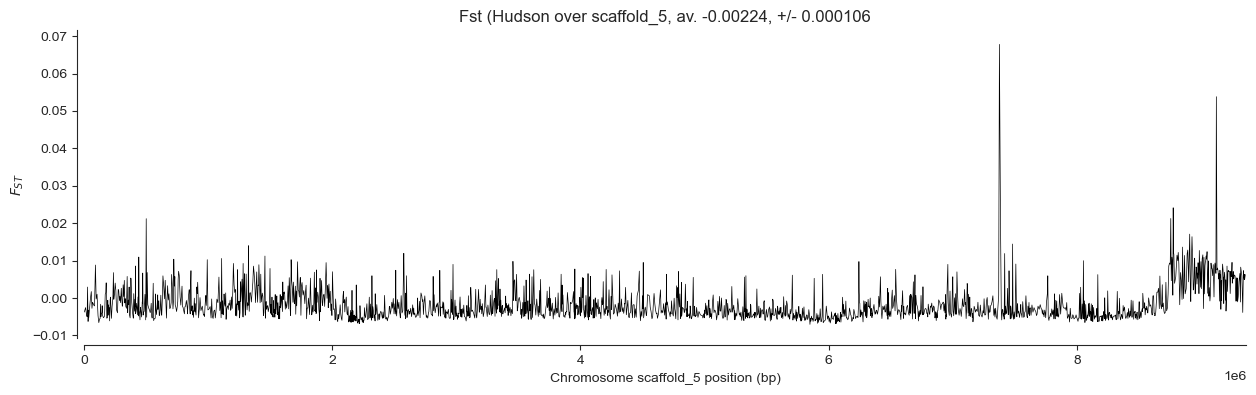

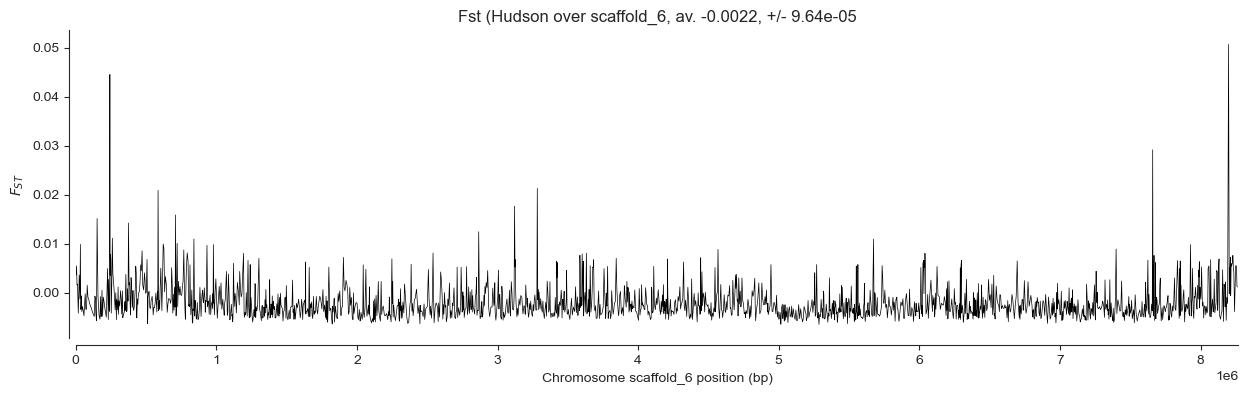

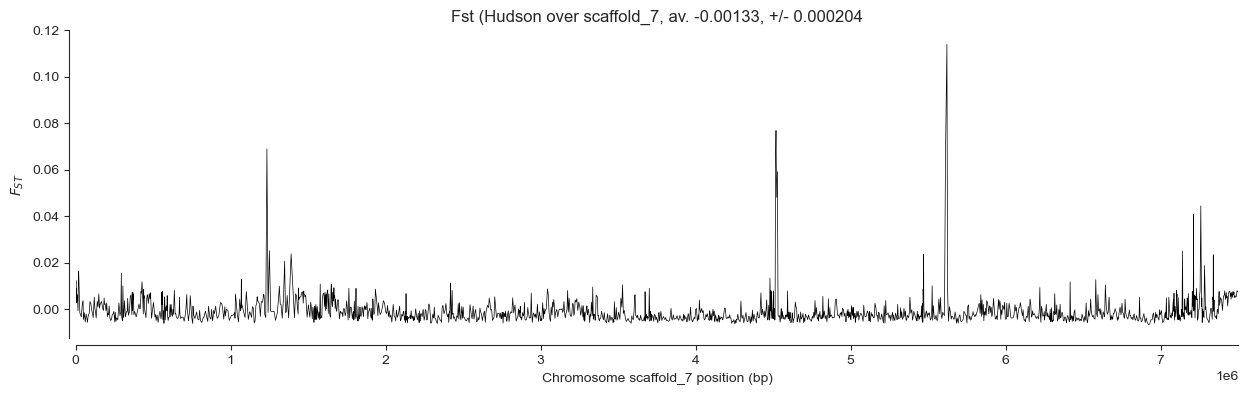

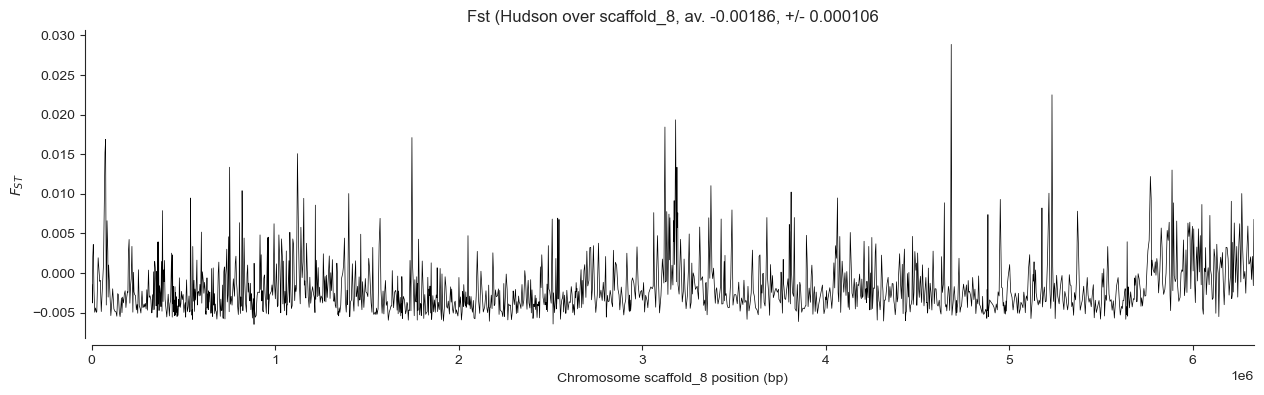

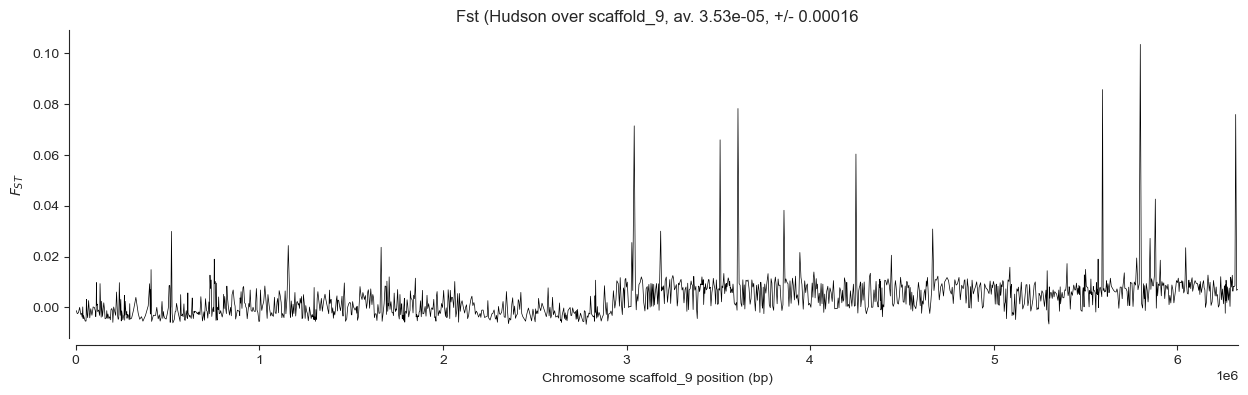

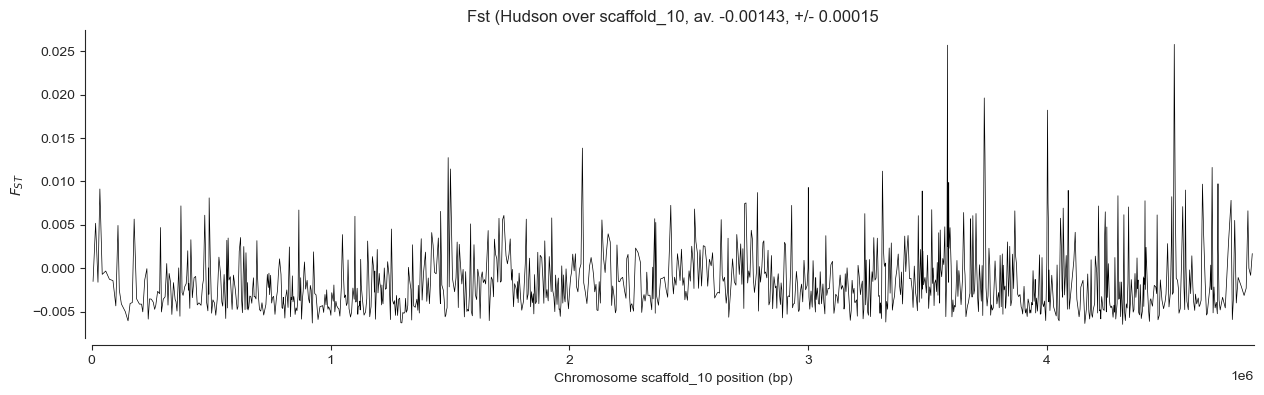

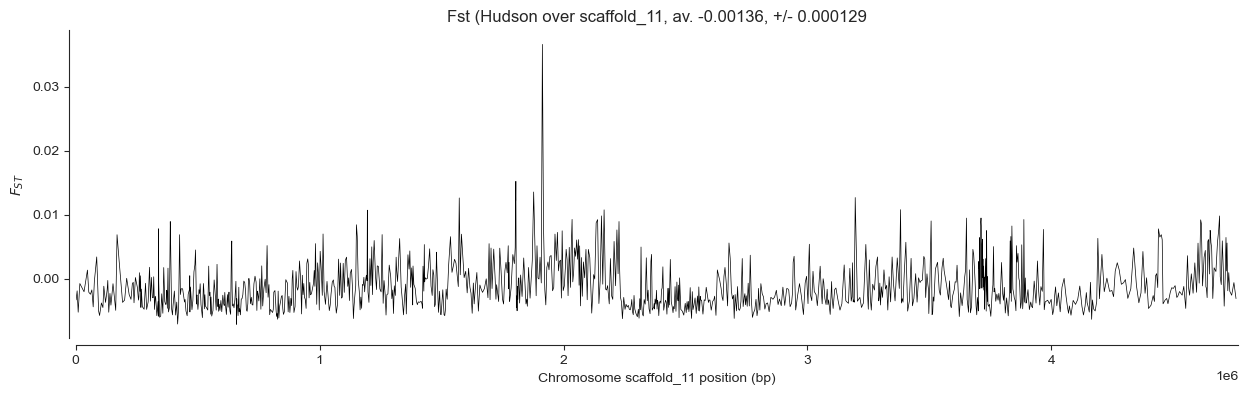

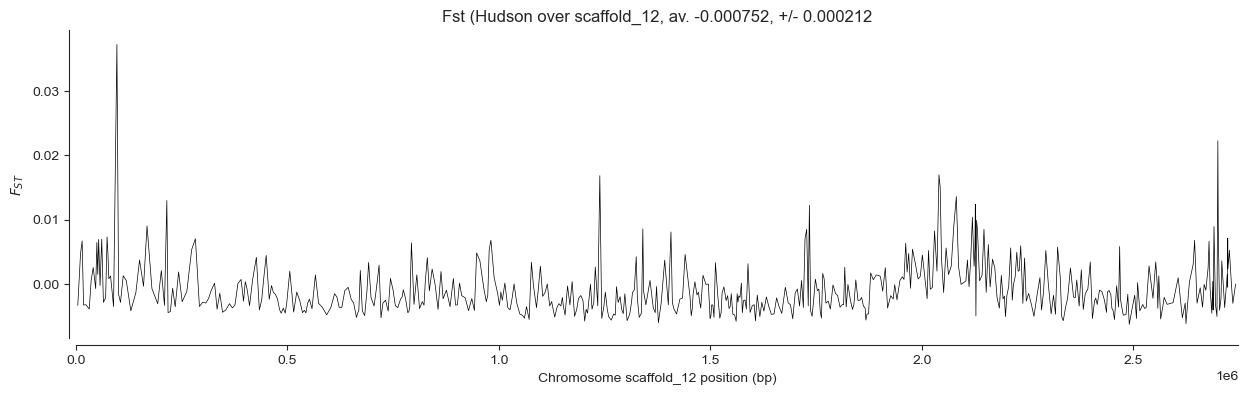

In [212]:
for f in (range(1,13)):
    scaf = 'scaffold_'+str(f)
    do_fst_scafpop('New_Zealand', 'South_America', scaf)

Ok, so, overall differentiation between NZ and SA is extremely low. Make sure you are looking at the y-scales, which I left free because it lets us look closer at the genome-wide diff (otherwise it would be pointless...).

I so see some blocks of the genome that are more differentiated. Given what we think is true about clonality - this doesn't have to be inversion, but just a chunk of the genome...if that makes sense. Even then, Fst still very low. The existing differentiation is probably due to undersampling in SA (or NZ, but probably more likely SA?). So - not much divergence between them.